#  Overview

Sentiment analysis involves identifying the attitude or opinion expressed in a piece of text, such as a document or speech. It has practical uses in areas like marketing, where customer feedback in the form of comments, reviews, and messages can be analyzed to improve business strategies. One common method for performing sentiment analysis is using a bag of words model, which represents a document as a numerical vector by counting the number of times each word appears. This is, of course, a substantial simplification as it disregards the linguistic structure of the document.

# Table of Contents

1. [Data: Twitter Airline Sentiment](#1.-Data:-Twitter-Airline-Sentiment)
2. [EDA and Data Preparation](#2.-Exploratory-Data-Analysis)
3. [Naive Bayes With Multiple Predictors](#3.-Naive-Bayes-With-Multiple-Predictors)
4. [Model Evaluation](#4.-Model-Evaluation)

In [1]:
import numpy as np
import pandas as pd

import nltk
import ast

import matplotlib.pyplot as plt
import seaborn as sns
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS as stopwords
import string
string.punctuation

from nltk.tokenize import TweetTokenizer

In [2]:
rc = {"xtick.labelsize": 12, "ytick.labelsize": 12, "axes.labelsize": 15, 
      "axes.titlesize": 15, "legend.fontsize": 12}
sns.set_context("notebook", rc=rc)  

## 1. Data: Twitter airline sentiment 

In this notebook, we use the Twitter Arline Sentiment dataset provided by a company called Crowdflower on the Kaggle datasets page. To build this dataset, the data scientists at Crowdflower scraped all tweets addressed to US airlines in February 2015, including metadata about the message. Human contributors then categorised each tweet according to the author's sentiment (positive, neutral, or negative).

In [3]:
data = pd.read_csv('Tweets.csv')
data.head(2)

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)


Example of a positive tweet:

In [4]:
print(data.loc[1, 'text'])

@VirginAmerica plus you've added commercials to the experience... tacky.


Example of a negative tweet:

In [5]:
print(data.loc[3, 'text'])

@VirginAmerica it's really aggressive to blast obnoxious "entertainment" in your guests' faces &amp; they have little recourse


## 2. EDA and Data Preparation

Exploring the dataset

In [6]:
#Visualizing the target outcomes

print(data['airline_sentiment'].unique())

['neutral' 'positive' 'negative']


In [7]:
#Dropping columns that will not be used

data = data.drop(['tweet_id', 'airline_sentiment_confidence', 'negativereason', 'negativereason_confidence', 
                  'airline_sentiment_gold', 'name', 'negativereason_gold', 'retweet_count', 'tweet_coord', 'tweet_created',
                 'tweet_location', 'user_timezone'], axis=1)

data.head(3)


,airline_sentiment,airline,text
0,neutral,Virgin America,@VirginAmerica What @dhepburn said.
1,positive,Virgin America,@VirginAmerica plus you've added commercials t...
2,neutral,Virgin America,@VirginAmerica I didn't today... Must mean I n...


In [8]:
data['airline_sentiment'].unique()

array(['neutral', 'positive', 'negative'], dtype=object)

In [9]:
#Removing neutral, since we will only be checking negative or positive

data = data[data['airline_sentiment'] != 'neutral']

It is visible that the majority of the tweets are negative

In [10]:
data['airline_sentiment'].value_counts()

negative    9178
positive    2363
Name: airline_sentiment, dtype: int64

In [11]:
#Creating dummy variables for the target values where positive = 0 and negative = 1

binary_class = set(data.airline_sentiment)
index = dict((a, b) for b, a in enumerate(binary_class))
index_to_class = dict((c, d) for d, c in index.items())

print(index)

{'positive': 0, 'negative': 1}


In [12]:
ids = lambda airline_sentiment: np.array([index.get(x) for x in airline_sentiment])

data['target'] = ids(data.airline_sentiment)

In [13]:
data.head(5)

,airline_sentiment,airline,text,target
1,positive,Virgin America,@VirginAmerica plus you've added commercials t...,0
3,negative,Virgin America,@VirginAmerica it's really aggressive to blast...,1
4,negative,Virgin America,@VirginAmerica and it's a really big bad thing...,1
5,negative,Virgin America,@VirginAmerica seriously would pay $30 a fligh...,1
6,positive,Virgin America,"@VirginAmerica yes, nearly every time I fly VX...",0


In [14]:
#Checking for null values

data.isnull().sum()

airline_sentiment    0
airline              0
text                 0
target               0
dtype: int64

In [15]:
#Cleaning symbols and emojis

import re

data['text'] = data['text'].apply(lambda x: re.sub(r'[^\w\s]', "", x))

In [16]:
data.head(3)

,airline_sentiment,airline,text,target
1,positive,Virgin America,VirginAmerica plus youve added commercials to ...,0
3,negative,Virgin America,VirginAmerica its really aggressive to blast o...,1
4,negative,Virgin America,VirginAmerica and its a really big bad thing a...,1


In [17]:
# Tokenazing the tweets, to split the phrases into single words

tweet = data.loc[1, 'text'] 
Tokenizer = TweetTokenizer()
tokenized = Tokenizer.tokenize(tweet)

print('Original:')
print(tweet)
print()
print('Tokenized:')
print(tokenized)

Original:
VirginAmerica plus youve added commercials to the experience tacky

Tokenized:
['VirginAmerica', 'plus', 'youve', 'added', 'commercials', 'to', 'the', 'experience', 'tacky']


### Cleaning & Tokenization

Common abbreviations and non-English words such as ‘LOL’, ‘bday’, ‘hahaha’, were replaced in the code below with a descriptive word to reduce the number of text features present. Stop words were used to identify and remove commonly used insignificant words that contain low-level information such as ‘is’, ‘the’ and ‘in’.

The removal of stop words gives the model more focus on words with more contextual importance, and the decrease of features will increase the speed of training models.

In [18]:
# Tokenizing, which is spliting a phrase into words
# Changing to lower case
# Removing stopwords
# Stemmer to cut the end the words such as trying -> try


def process_text(text):
    
    tokenized = Tokenizer.tokenize(text)
    
    processed = []
    for word in tokenized:
        if word not in string.punctuation:
            word = word.lower()
            if word not in stopwords:
                processed.append(PorterStemmer().stem(word))
    
    return processed

In [19]:
data['tokens'] = data['text'].apply(process_text)

In [20]:
data['tokens']

1        [virginamerica, plu, youv, ad, commerci, exper...
3        [virginamerica, realli, aggress, blast, obnoxi...
4                 [virginamerica, realli, big, bad, thing]
5        [virginamerica, serious, pay, 30, flight, seat...
6        [virginamerica, ye, nearli, time, fli, vx, ear...
                               ...                        
14633    [americanair, flight, cancel, flightl, leav, t...
14634                     [americanair, right, cue, delay]
14635    [americanair, thank, got, differ, flight, chic...
14636    [americanair, leav, 20, minut, late, flight, w...
14638    [americanair, money, chang, flight, dont, answ...
Name: tokens, Length: 11541, dtype: object

In [21]:
#Splitting the data into train and test

from sklearn.model_selection import train_test_split

train, test = train_test_split(data, train_size=0.7, random_state=1)

In [22]:
train['airline_sentiment'].value_counts()

negative    6404
positive    1674
Name: airline_sentiment, dtype: int64

### Tweets per airline

A cross tabulation to break down the numbers by airline. 
American, US Airways, and United in particular had a high proportion of complaints that month:

In [23]:
table = pd.crosstab(train['airline_sentiment'], train['airline'])
table

airline,American,Delta,Southwest,US Airways,United,Virgin America
airline_sentiment,,,,,,
negative,1396,656,823,1585,1813,131
positive,248,400,394,192,347,93




One of the challenges in building the classifier will be to select the predictors to include in the model. A good way to start is to explore the most common words in each type of document. We first consider the most common words in the data as a whole.

FreqDist was used to to count the frequency of each word, i.e. the number of times the word appears.

In [24]:
frequency = nltk.FreqDist()
for words in train['tokens']:
    wordlist = ast.literal_eval(str(words))
    for word in wordlist:
        frequency[word] += 1

print(frequency.most_common()[:8])

[('flight', 2872), ('unit', 2372), ('usairway', 1858), ('americanair', 1753), ('southwestair', 1236), ('jetblu', 1162), ('thank', 1037), ('hour', 800)]


### Visualization of the frequency of words

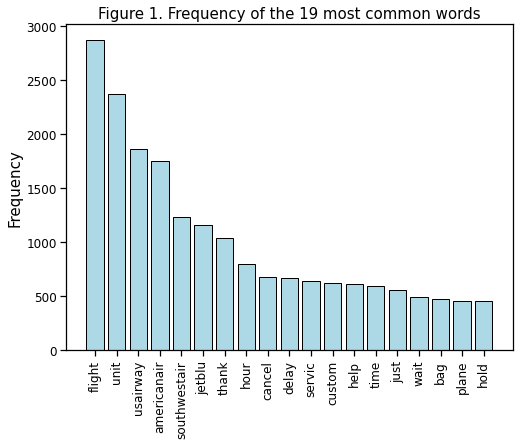

In [25]:
n = 19
frequency_data = pd.Series(dict(frequency.most_common()[:n]))

fig, ax = plt.subplots(figsize=(8, 6))
plt.bar(np.arange(0, n), frequency_data, color='lightblue', edgecolor='black')
plt.xticks(np.arange(0, n), frequency_data.index, rotation=90)
plt.ylabel('Frequency')
plt.title('Figure 1. Frequency of the {} most common words'.format(n));


### Positive and Negative words

It is visible in the analysis below that nearly half of the positive tweets contain the word "thank". Additionally, words such as "great", "love", "best", and "awesome" are among the most frequent in positive tweets and do not appear among the most frequent in negative tweets. Similarly, "delay", "cancel", and "wait" are among the most frequent for negative tweets and are not among the most frequent for positive tweets.

In [26]:
positive_tweets = train[train['airline_sentiment'] == 'positive']

freq_positive = nltk.FreqDist()
for words in positive_tweets['tokens']:
    wordlist = ast.literal_eval(str(words))
    for word in np.unique(wordlist): # not counting repeated words this time
        freq_positive[word] += 1

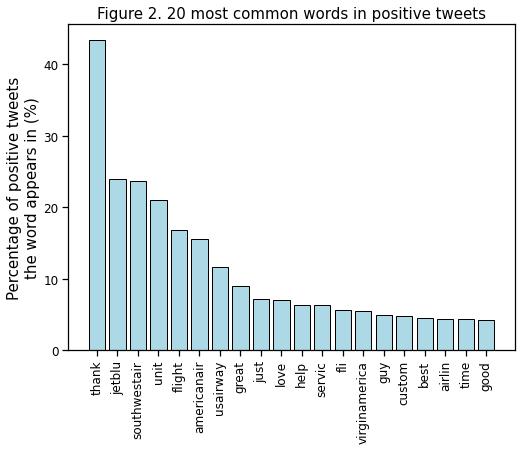

In [27]:
n = 20
frequency_data = pd.Series(dict(freq_positive.most_common()[:n]))
n_positive_tweets = len(positive_tweets)
percentage_data = frequency_data/n_positive_tweets * 100

fig, ax = plt.subplots(figsize=(8, 6))
plt.bar(np.arange(0, n), percentage_data, color='lightblue', edgecolor='black')
plt.xticks(np.arange(0, n), percentage_data.index, rotation=90)
plt.ylabel('Percentage of positive tweets\nthe word appears in (%)')
plt.title('Figure 2. {} most common words in positive tweets'.format(n));

In [28]:
negative_tweets = train[train['airline_sentiment'] == 'negative']

freq_negative = nltk.FreqDist()
for words in negative_tweets['tokens']:
    wordlist = ast.literal_eval(str(words))
    for word in np.unique(wordlist):
        freq_negative[word] += 1

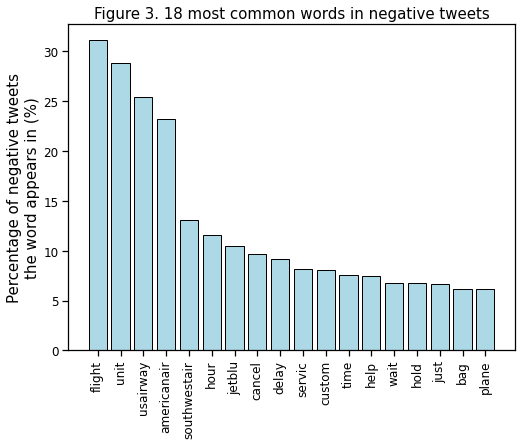

In [29]:
n = 18
frequency_data = pd.Series(dict(freq_negative.most_common()[:n]))
n_negative_tweets = len(negative_tweets)
percentage_data = frequency_data/n_negative_tweets * 100

fig, ax = plt.subplots(figsize=(8, 6))
plt.bar(np.arange(0, n), percentage_data, color='lightblue', edgecolor='black')
plt.xticks(np.arange(0, n), percentage_data.index, rotation=90)
plt.ylabel('Percentage of negative tweets\nthe word appears in (%)')
plt.title('Figure 3. {} most common words in negative tweets'.format(n));

In [30]:
# taking each element in the "tokens" column, which is assumed to be a list of strings, 
# and joining them into a single string with spaces in between the tokens 

train_join = train["tokens"].map(' '.join)
test_join = test["tokens"].map(' '.join)

First it is required to construct a predictor storing the bag of words representation for this. If a tweet contains 'thank' the predictor will have a 1, otherwise it will have a 0. The following calculates the bag of words representation on all of the data.

In [31]:
from sklearn.feature_extraction.text import CountVectorizer

train_corpus = train_join
test_corpus = test_join

count_vectorizer = CountVectorizer(binary=True)
count_vectorizer.fit(train_corpus)

bow_train = count_vectorizer.transform(train_corpus)
bow_test = count_vectorizer.transform(test_corpus)

In [32]:
#Checking with the word 'thank'

thank_index = count_vectorizer.get_feature_names().index('thank')
X_train = bow_train[:, thank_index].todense()
X_test = bow_test[:, thank_index].todense()

C:\Users\ericp\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [33]:
# 1 is where the work 'thank' was used

X_train[15:25]

matrix([[0],
        [0],
        [0],
        [0],
        [1],
        [0],
        [0],
        [0],
        [0],
        [1]], dtype=int64)

You can see that tweet 7593 and 2205 contains the word 'thank'. Hence, this tweet is marked with a 1 in X_train.

In [34]:
train[15:25]

,airline_sentiment,airline,text,target,tokens
9901,negative,US Airways,USAirways please help No bags no way to get th...,1,"[usairway, help, bag, way, custom, servic, 8am..."
6134,positive,Southwest,SouthwestAir just had a great flight 4223 with...,0,"[southwestair, just, great, flight, 4223, dami..."
11929,negative,American,AmericanAir dont worry Ill be sending a letter...,1,"[americanair, dont, worri, ill, send, letter, ..."
9726,negative,US Airways,USAirways PHLAirport always nice when a custom...,1,"[usairway, phlairport, nice, custom, servic, m..."
7593,positive,Delta,JetBlue got it thanks the quick reply,0,"[jetblu, got, thank, quick, repli]"
11298,negative,US Airways,USAirways well this is nofun nocustomerservice...,1,"[usairway, nofun, nocustomerservic, onhold, tr..."
9070,negative,US Airways,USAirways Beamske how about a real live person...,1,"[usairway, beamsk, real, live, person, talk, p..."
1397,negative,United,united why do you want me to be loyal if dont...,1,"[unit, want, loyal, dont, let, carri, bag, eas..."
4409,negative,Southwest,SouthwestAir Rapid Rewards program sold me sho...,1,"[southwestair, rapid, reward, program, sold, s..."
2205,positive,United,united Thanks for the upgrade please try to ge...,0,"[unit, thank, upgrad, tri, compani, approv, bu..."


## 3. Naive Bayes

Building the Model and checking the accuracy before improving it

In [35]:
from sklearn.naive_bayes import BernoulliNB
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings("ignore")

y_train = train['target'] 
y_test = test['target']

nbc = BernoulliNB().fit(X_train, y_train)

pred = cross_val_predict(nbc, X_train, y_train, cv=5)
error = 1 - accuracy_score(pred, y_train)

print(error.round(3))

0.152


### Predictors
It is important to identify which predictors will be useful, and also in which order it will add the predictors.
Therefore, it was decided to only keep words that appear in at least 10 tweets. Dropping to 990 predictors.

In [36]:
freq_count = np.array(bow_train.sum(axis = 0))
predictors = np.array(count_vectorizer.get_feature_names())[freq_count[0] >= 10]
len(predictors)

990



The code below ranks each predictors based on how well each of them individually performs on the dataset with the BernoulliNB classifier.

This metric penalises the model if its predicted probability of the true class is very low. E.g. the tweet is positive but the model predicts the positive class with a very low probability.

In [37]:
from sklearn.metrics import log_loss

results = pd.DataFrame(columns=['Loss'])

for word in predictors:

    word_index = count_vectorizer.get_feature_names().index(word)
    X_train = bow_train[:, word_index].todense()
    X_test = bow_test[:, word_index].todense()

    nbc = BernoulliNB().fit(X_train, y_train)

    prob = nbc.predict_proba(X_train)
    results.loc[word] = log_loss(y_train, prob)

The code below is an order of how 'useful' the predictors are:

In [38]:
results.sort_values('Loss')

,Loss
thank,0.418523
great,0.492926
hour,0.493266
love,0.498602
jetblu,0.498696
...,...
cc,0.510271
gotta,0.510271
inbound,0.510271
domest,0.510271


In [39]:
ordered_predictors = list(results.sort_values('Loss').index)

### Multiple Predictors

In [40]:
def compute_naive_bayes_model(n_predictors):
    # Identify the columns corresponding to the predictors we are using
    indices = []
    for word in ordered_predictors[:n_predictors+1]:
        indices.append(count_vectorizer.get_feature_names().index(word))
    
    X_train = bow_train[:, indices].todense()
    X_test = bow_test[:, indices].todense()
    
    nbc = BernoulliNB().fit(X_train, y_train)

    pred = cross_val_predict(nbc, X_train, y_train, cv=5)
    error = 1 - accuracy_score(pred, y_train)
    
    return error*100

### Visualizing the optimal number of predictors 

In [41]:
cv_errors = []
predictor_range = range(0, len(ordered_predictors), 50)

for n_predictors in predictor_range:
    cv_errors.append(compute_naive_bayes_model(n_predictors))

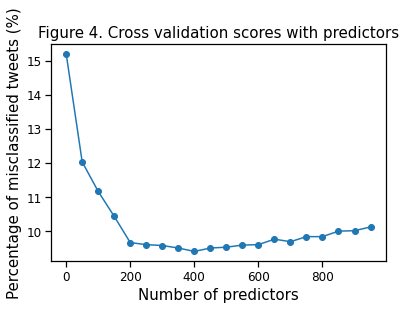

In [42]:
plt.plot(predictor_range, cv_errors, '-o')
plt.xlabel('Number of predictors')
plt.ylabel('Percentage of misclassified tweets (%)')
plt.title('Figure 4. Cross validation scores with predictors');

In [43]:
cv_errors = []
predictor_range = range(400, 550, 10)

for n_predictors in predictor_range:
    cv_errors.append(compute_naive_bayes_model(n_predictors))

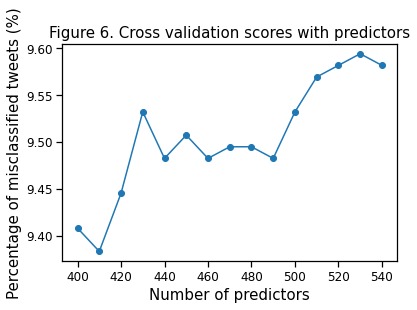

In [44]:
plt.plot(predictor_range, cv_errors, '-o')
plt.xlabel('Number of predictors')
plt.ylabel('Percentage of misclassified tweets (%)')
plt.title('Figure 6. Cross validation scores with predictors');

The best number of predictors to use is 410, which has an error of 9.4 i.e. it misclassifies 9.4% of the tweets.

In [45]:
print('Number of predictors:', predictor_range[np.argmin(cv_errors)])
print('Error: {:.1f}'.format(cv_errors[np.argmin(cv_errors)]))

Number of predictors: 410
Error: 9.4


# 4. Model Evaluation

Evaluating the model with 410 predictors

In [46]:
# Model evaluation

indices = []
for word in ordered_predictors[:410]:
    indices.append(count_vectorizer.get_feature_names().index(word))
    
X_train = bow_train[:, indices].todense()
X_test = bow_test[:, indices].todense()

nbc = BernoulliNB().fit(X_train, y_train)

pred = nbc.predict(X_test)
prob = nbc.predict_proba(X_test)[:, 1] # probability of the positive class

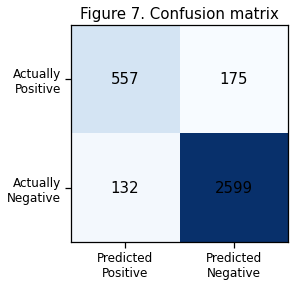

In [47]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, pred)
plt.imshow(cm, cmap='Blues')

plt.text(0, 0, cm[0, 0], ha="center", va="center", color="k", fontsize = 15) 
plt.text(0, 1, cm[0, 1], ha="center", va="center", color="k", fontsize = 15) 
plt.text(1, 0, cm[1, 0], ha="center", va="center", color="k", fontsize = 15) 
plt.text(1, 1, cm[1, 1], ha="center", va="center", color="k", fontsize = 15) 
plt.xticks([1, 0], ['Predicted\nNegative', 'Predicted\nPositive'])    
plt.yticks([1, 0], ['Actually\nNegative', 'Actually\nPositive'])    
plt.title('Figure 7. Confusion matrix')
plt.show()

Table with common classification metrics.

- Precision: of the samples we predicted to be positive, how many were actually positive:

$$\text{Precision}=\frac{TP}{\text{Classified positive} }=\frac{TP}{TP\ +\ FP}$$

- Recall: of the samples that are actually positive, how many were classified as positive:

$$\text{Recall}\ =\frac{TP}{\text{Actually positive}}=\ \frac{TP}{TP+FN}$$


- F1 score: the harmonic mean of precision and recall
$$\text{F}_1=\frac{2}{\text{recall}^{-1}+\text{precision}^{-1}}=\frac{2\ \times\text{precision} \times \text{recall}}{\text{precision + recall}}$$

In [48]:
results = pd.DataFrame(columns=['Naive Bayes'])

results.loc['% Misclassified'] = (1 - accuracy_score(pred, y_test))*100

tn, fp, fn, tp = cm.ravel()
precision = tp/(tp + fp)
recall = tp/(tp + fn)
results.loc['Precision'] = precision
results.loc['Recall'] = recall
results.loc['F1 scores'] = (2 * precision * recall)/(precision + recall)

In [49]:
results.round(2)

,Naive Bayes
% Misclassified,8.87
Precision,0.95
Recall,0.94
F1 scores,0.94
